In [1]:
import MDAnalysis as mda
atomistic_system = mda.Universe
from modules.distances import *
from modules.dssp import dssp
from modules.input import res_list, show_fasta
from typing import Tuple
%reload_ext autoreload
%autoreload 2
import input
import MDAnalysis.analysis.align as align

In [2]:
atomistic_system, reference_structure, energy_like_terms, is_aligned = input.read_files()
is_aligned = input.align_traj(is_aligned)

Aligned file found, reading this instead
Trajectory allready aligned, delete md250ns_center_po_aligned.xtc to rerun alignement


In [3]:
show_fasta(atomistic_system)

----5----10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95---100--105--110--115--120--125--130--135--140--145--150--155--160--165--170--
TTAPEAPSVNDTEVGSKKVSGKGHEVGNTVTVTFPDGKTATSKVDEKGNWTVDVPEGTELKVGNEITATETDMSGNKSESGKGKVTDTTAPEAPSVNDTEVGSKKVSGKGHEVGNTVTVTFPDGKTATSKVDEKGNWTVDVPEGTELKVGNEITATETDMSGNKSESGKGKVTD
--------E--EE----EEEEE------EEEEE-----EEEEEE----EEEEE-------------EEEEE-----E---EE--EE---------E--E-----EEEEE------EEEEE-----EEEEEE----EEEEE-----------EEEEEEE-----E---EEEEE--


In [4]:
#Select 2 vectors as 4 list of residues to get 4 center of mass
list_resA = [6,18,29,39,49,66]
list_resB = [12,22,33,44,53,72]
list_resC = [x+87 for x in list_resA]
list_resD = [x+87 for x in list_resB] 

def list_to_selection(res_list: list):
    sele = ""
    for resid in res_list:
        sele = sele + f"resid {resid}"
        if resid != res_list[-1]:
            sele = sele + " or "
    return sele

seleA = list_to_selection(list_resA)
seleB = list_to_selection(list_resB)
seleC = list_to_selection(list_resC)
seleD = list_to_selection(list_resD)

def get_vector_CoM(atomistic_system, seleA, seleB):
    CoM_A = atomistic_system.select_atoms(seleA).center_of_mass()
    CoM_B = atomistic_system.select_atoms(seleB).center_of_mass()
    vector = np.array([CoM_B[0] - CoM_A[0], CoM_B[1] - CoM_A[1], CoM_B[2] - CoM_A[2]])
    return vector

In [5]:
#Print a pymol script 
CoM_A = atomistic_system.select_atoms(seleA).center_of_mass()
CoM_B = atomistic_system.select_atoms(seleB).center_of_mass()
CoM_C = atomistic_system.select_atoms(seleC).center_of_mass()
CoM_D = atomistic_system.select_atoms(seleD).center_of_mass()
print(f"pseudoatom CoM_A, pos = [{CoM_A[0]}, {CoM_A[1]}, {CoM_A[2]}]")
print(f"pseudoatom CoM_B, pos = [{CoM_B[0]}, {CoM_B[1]}, {CoM_B[2]}]")
print("distance /CoM_A, /CoM_B")
print(f"pseudoatom CoM_C, pos = [{CoM_C[0]}, {CoM_C[1]}, {CoM_C[2]}]")
print(f"pseudoatom CoM_D, pos = [{CoM_D[0]}, {CoM_D[1]}, {CoM_D[2]}]")
print("distance /CoM_C, /CoM_D")

pseudoatom CoM_A, pos = [92.11580469888263, 78.23260355999473, 22.453912341832595]
pseudoatom CoM_B, pos = [94.01358655824389, 78.81473605773358, 23.913627905384697]
distance /CoM_A, /CoM_B
pseudoatom CoM_C, pos = [55.090227133617404, 72.39604663696223, 42.61809094694207]
pseudoatom CoM_D, pos = [55.5223864681388, 73.53459394740955, 40.627462644120634]
distance /CoM_C, /CoM_D


In [6]:
# vetor from PCA
sele_residues_vectorA = "(resid 10 to 80) and name CA"
sele_residues_vectorB = "(resid 97 to 167) and name CA"

def get_vector_PCA(atomistic_system, sele):
    CAs = atomistic_system.select_atoms(sele).positions
    mean_point = np.mean(CAs, axis=0)
    cov_matrix = np.cov((CAs - mean_point).T)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    dominating_direction = eigenvectors[:, np.argmax(eigenvalues)]
    return dominating_direction

In [23]:
reference = atomistic_system.select_atoms(sele_residues_vectorA)
aligner = align.AlignTraj(atomistic_system, reference, 
                                select=sele_residues_vectorA,
                                in_memory=False, 
                                filename=input.sim_path + input.trajectory_file_name.split(".")[0] + "_vector_aligned.xtc")
aligner.run(verbose=True)


  0%|          | 0/25001 [00:00<?, ?it/s]

In [ ]:
atomistic_system_aligned = mda.Universe(f"{input.sim_path}{input.coordinate_file_name}", f"{input.sim_path}{input.trajectory_file_name.split(".")[0]}_vector_aligned.xtc")
print(atomistic_system_aligned.residues[0].resid)

In [144]:

angles = []
for ts in atomistic_system_aligned.trajectory:
    #if atomistic_system.trajectory.time > 5000:
    #    break
    vector1 = get_vector_CoM(atomistic_system_aligned,seleA,seleB)
    vector2 = get_vector_CoM(atomistic_system_aligned,seleC,seleD)
    #vector1 = get_vector_PCA(atomistic_system,sele_residues_vectorA)
    #vector2 = get_vector_PCA(atomistic_system,sele_residues_vectorB)
    dot_product = np.dot(vector1, vector2)

    # Calculate magnitudes
    magnitude_vector1 = np.linalg.norm(vector1)
    magnitude_vector2 = np.linalg.norm(vector2)

    # Calculate the angle in radians
    angle_radians = np.arccos(dot_product / (magnitude_vector1 * magnitude_vector2))

    # Convert angle to degrees
    angle_degrees = np.degrees(angle_radians)
    
    # Calculate the angle between the two vectors as a polar coordinate
    # with respect to the direction of the first vector
    angle_polar = np.arctan2(vector2[1], vector2[0]) - np.arctan2(vector1[1], vector1[0]) 

    angles.append([atomistic_system.trajectory.time, angle_degrees, angle_polar])


angles = np.array(angles)

In [130]:
vectors = []
for ts in atomistic_system_aligned.trajectory:
    #vector1 = get_vector_CoM(atomistic_system_aligned,seleA,seleB)
    vectorA = get_vector_PCA(atomistic_system_aligned,sele_residues_vectorA)
    vectorB= get_vector_PCA(atomistic_system_aligned,sele_residues_vectorB)
    #vector2 = get_vector_CoM(atomistic_system_aligned,seleC,seleD)
    #vector3 = get_vector_CoM(atomistic_system_aligned,seleA,seleD)
    #v = vector3 - vector1
    vA_norm = vectorA/np.linalg.norm(vectorA)
    vB_norm = vectorB/np.linalg.norm(vectorB)
    vectors.append((vA_norm, vB_norm, ))

In [132]:
print(vectors[0])

(array([0.9753138 , 0.19799062, 0.0977891 ]), array([ 0.58899063,  0.0815995 , -0.80400967]))


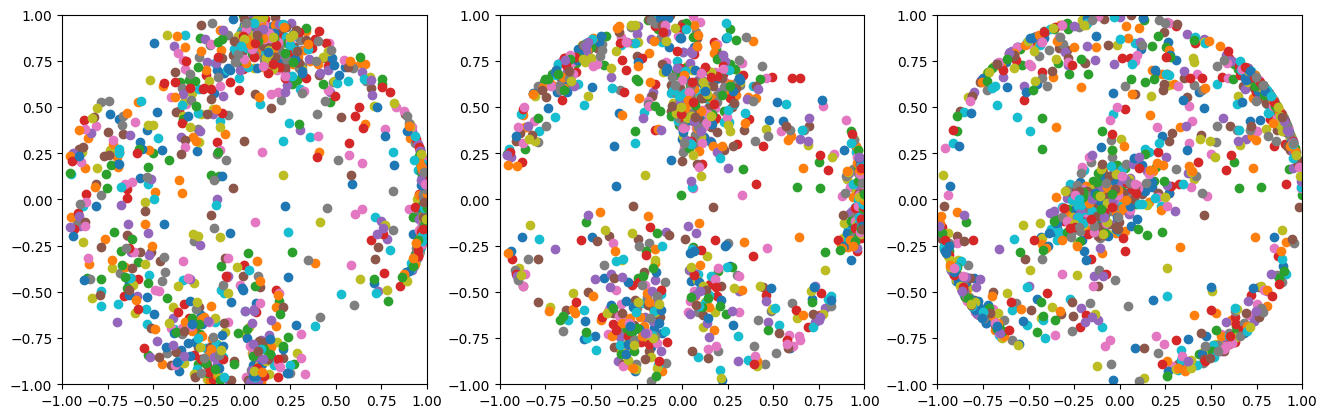

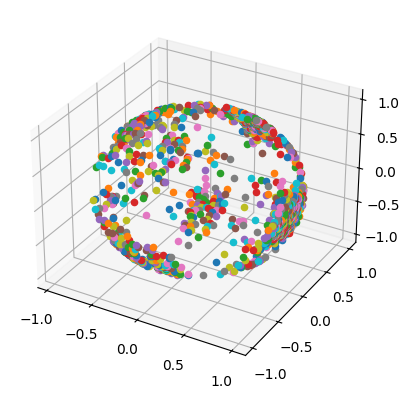

In [138]:
fig, axs = plt.subplots(1,3)
fig.set(figwidth=16)
axs[0].set_xlim(-1,1)
axs[0].set_ylim(-1,1)
axs[1].set_xlim(-1,1)
axs[1].set_ylim(-1,1)
axs[2].set_xlim(-1,1)
axs[2].set_ylim(-1,1)
step = 20
vec = 1

for i in range(0, len(vectors), step):
    axs[0].scatter(vectors[i][vec][0], vectors[i][vec][1])
    
for i in range(0, len(vectors), step):
    axs[1].scatter(vectors[i][vec][0], vectors[i][vec][2])

for i in range(0, len(vectors), step):
    axs[2].scatter(vectors[i][vec][1], vectors[i][vec][2])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(0, len(vectors), step):
    ax.scatter(vectors[i][vec][0], vectors[i][vec][1],vectors[i][vec][2])


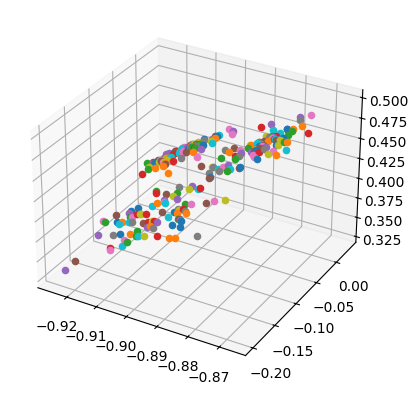

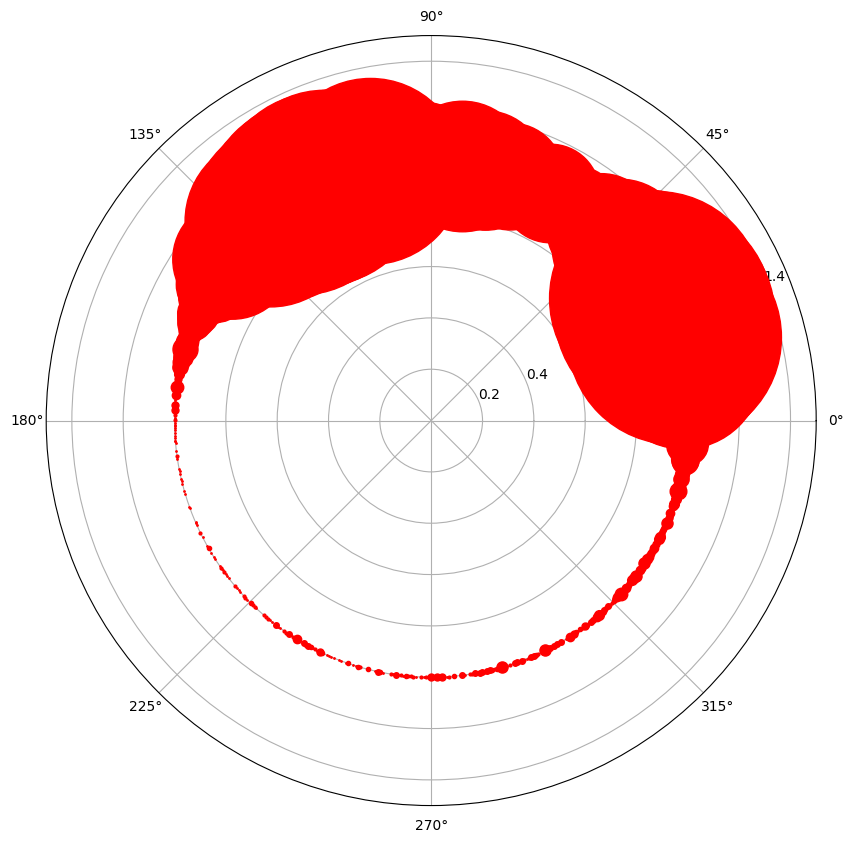

In [145]:
# Plot the polar plot
polar_angles = np.array(angles.T[2])
rounded_angles = np.round(polar_angles, decimals=2)
unique_rounded_angles, counts = np.unique(rounded_angles, return_counts=True)
marker_sizes = counts * 10

fig = plt.figure()
fig.set(figwidth= 10, figheight=10)
ax = plt.subplot(111, projection='polar')
for i, angle in enumerate(unique_rounded_angles):
    ax.plot(angle, 1,  marker='o', markersize=marker_sizes[i]/10, color='r', linestyle='None')


ax.set_rmax(1.5)  # Set the maximum radius of the plot

#fig2 = plt.figure()
#fig2.set(figwidth= 10, figheight=10)
#ax2= plt.subplot()
#angles_T = angles.T
#ax2.plot(angles_T[0]/1000, angles_T[1])
#plt_smooth(ax2, angles_T[1], angles_T[0], 1000)
#plt.show()

138.03357036487827


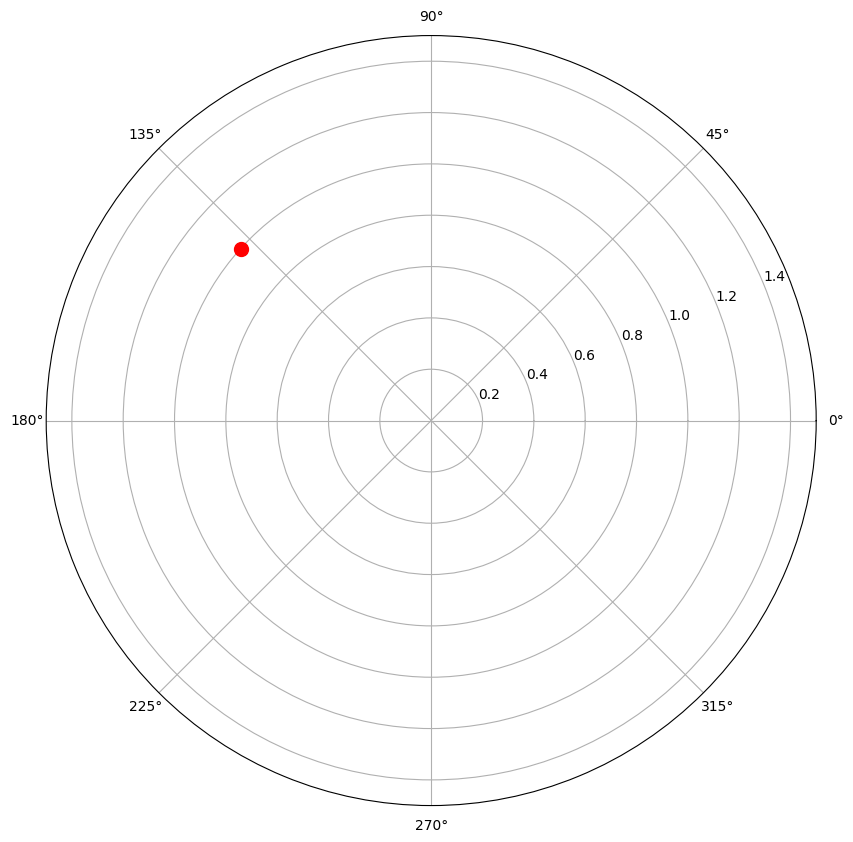

In [162]:
# Plot the polar plot
timepoint = 21123

polar_angles = np.array(angles.T[2])

fig = plt.figure()
fig.set(figwidth= 10, figheight=10)
ax = plt.subplot(111, projection='polar')
ax.plot(polar_angles[timepoint], 1,  marker='o', markersize=10, color='r', linestyle='None')
print(polar_angles[timepoint]*180/3.14)
ax.set_rmax(1.5)  # Set the maximum radius of the plot

